# Árvore de Decisão e Floresta Aleatória
**Primeira Tentativa** \\
 \\
Bootcamp Machine Learning ENAP 2024 \\
Maurício Marques Soares Filho \\
13/10/2024 \\

## Imports...

In [1]:
# Importar bibliotecas numpy e pandas
import numpy as np
import pandas as pd

# Importar OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Importar bibliotecas de balanceamento
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE

# Importar confusion_matrix, plot_confusion_matrix, accuracy_score, train_test_split, matplotliby
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Importar DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Importar Random Forest
from sklearn.ensemble import RandomForestClassifier
import dtreeviz

# Anular Avisos
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Pré-processamento dos dados

In [2]:
#Estilizar conteúdo
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},  # Azul abaixo do nome das colunas
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},  # Fundo alternado
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'background-color': '#f4f4f4', 'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'
        ).format(
            precision=casas_decimais
        )
    )

In [3]:
# Pré-processamento dos dados
object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

estilo_tabelas(df_eventos.head(5))

/var/folders/cj/_95ntbkj60b_pjvf32tvsh2h0000gn/T/ipykernel_10290/3543285895.py:11: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eventos = pd.read_csv(


,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,codigo_ibge,Setores Censitários,Status,DH_Descricao,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Descricao,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,DA_Descricao,DA_Polui/cont da água,DA_Polui/cont do ar,DA_Polui/cont do solo,DA_Dimi/exauri hídrico,DA_Incêndi parques/APA's/APP's,PEPL_Descricao,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Descricao,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,Município - UF,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Categoria,Grupo,Subgrupo,Tipo,Subtipo,COBRADE,Pop
0,SP-A-3550001-12200-20100101,São Luiz do Paraitinga,SP,Sudeste,2010-01-01,2010-01-01,3550001,nan,Reconhecido,nan,0,0,0,93,4030,0,16,4139,nan,49,20,20643486.932,3.000,0,1121928.638,9.000,1,5235666.976,0,0,0.000,3,3,32411.272,25.000,0.000,65321178.458,92354672.275,nan,nan,nan,nan,nan,nan,nan,7978.159,673157.183,623293.688,2493.175,0.000,330993.880,3739.762,58609.552,0.000,0.000,1087024.191,2787289.589,nan,1642902.433,1149353.560,379785.310,0.000,24433.113,3196474.416,5983764.005,2010,nan,nan,nan,São Luiz do Paraitinga - SP,86448.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Enxurradas,nan,nan,12200,10397.000
1,SP-A-3518305-11321-20100101,Guararema,SP,Sudeste,2010-01-01,2010-01-01,3518305,nan,Reconhecido,nan,4,2,0,66,417,0,14430,14919,nan,161,91,18604069.987,0.000,0,0.000,2.000,0,24931.748,0,0,0.000,0,0,37397.621,9000.000,0.000,57771845.314,76438244.669,nan,nan,nan,nan,nan,nan,nan,0.000,179508.582,264276.524,12465.874,0.000,349044.465,74795.243,134631.437,0.000,0.000,77288.417,1092010.541,nan,441291.931,2049389.645,0.000,0.000,112192.889,2602874.464,3694885.005,2010,nan,nan,nan,Guararema - SP,1111405.000,nan,nan,nan,nan,nan,nan,Natural,Geológico,Movimento de massa,Deslizamentos,Deslizamentos de solo e ou rocha,11321,25844.000
2,BA-A-2905909-14110-20100101,Campo Alegre de Lourdes,BA,Nordeste,2010-01-01,2010-01-01,2905909,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,747.952,448771.455,0.000,0.000,0.000,0.000,0.000,249317.475,0.000,0.000,177015.407,875852.290,nan,254303.825,147097.310,0.000,0.000,0.000,401401.135,1277253.425,2010,nan,9.638,2914.587,Campo Alegre de Lourdes - BA,107459.000,nan,nan,nan,nan,nan,nan,Natural,Climatológico,Seca,Estiagem,nan,14110,28090.000
3,SP-A-3513603-12100-20100101,Cunha,SP,Sudeste,2010-01-01,2010-01-01,3513603,nan,Reconhecido,nan,6,0,0,38,492,0,12000,12536,nan,89,9,3340854.165,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,3.000,400.000,8052097.614,11392951.779,nan,nan,nan,nan,nan,nan,nan,0.000,1246.587,0.000,0.000,0.000,1994539.800,0.000,125656.007,0.000,0.000,0.000,2121442.395,nan,49863.495,1383711.986,0.000,0.000,925466.467,2359041.949,4480484.344,2010,nan,15.538,1407.250,Cunha - SP,112225.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Inundações,nan,nan,12100,21866.000
4,BA-P-2917334-12200-20100101,Iuiu,BA,Nordeste,2010-01-01,2010-01-01,2917334,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,

In [4]:
# Excluir variáveis que não serão adicionadas ao modelo
df_eventos = df_eventos.drop(['Protocolo_S2iD', 'Nome_Municipio', 'codigo_ibge', 'Data_Registro', 'Data_Evento'], axis = 1)
df_eventos = df_eventos.dropna(axis = 1)

In [5]:
#dimensões do dataset
print("Dimensões da base de dados: ", df_eventos.shape)

Dimensões da base de dados:  (26258, 53)


In [6]:
# Encoding das variáveis categóricas
encoder = OneHotEncoder(sparse_output = False, drop = None)
categorias = ['Sigla_UF', 'regiao', 'Categoria', 'Grupo']
one_hot_encoded = encoder.fit_transform(df_eventos[categorias])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorias))
df_eventos = pd.concat([df_eventos.drop(columns=categorias), one_hot_df], axis = 1)
df_eventos['Status'] = df_eventos['Status'].map({'Reconhecido': 1, 'Não reconhecido': 0})

# Balanceamento dos Dados I

In [7]:
# Shuffle...
df_novo = df_eventos.sample(frac = 1, random_state = 13).reset_index(drop = True)

In [8]:
# Atribuir valores para X e y
X = df_novo.iloc[:,1:]
y = df_novo.Status

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [9]:
# Oversampling da Minoritária

# Mostrar distribuição da variável target por classe
print("Distribuição da variável target: ", Counter(y_train))
# define estratégia oversampling
over = RandomOverSampler(random_state = 42, sampling_strategy = 0.8) # aumenta minoritária = 80% da majoritária.
# treina e aplica a transformação
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)
# Mostrar distribuição da variável target por classe
print("Distribuição da variável target após oversampling: ", Counter(y_train_resampled))

Distribuição da variável target:  Counter({1: 16709, 0: 1671})
Distribuição da variável target após oversampling:  Counter({1: 16709, 0: 13367})


In [10]:
# Undersampling da Majoritária

# Mostrar distribuição da variável target por classe
print("Distribuição da variável target: ", Counter(y_train_resampled))
# define estratégia undersampling
under = RandomUnderSampler(random_state=42) # diminui majoritária = minoritária.
# treina e aplica a transformação
X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)
# Mostrar distribuição da variável target por classe
print("Distribuição da variável target após undersampling: ", Counter(y_train_resampled))

Distribuição da variável target:  Counter({1: 16709, 0: 13367})
Distribuição da variável target após undersampling:  Counter({0: 13367, 1: 13367})


In [11]:
# Atribuir valores para X e y
X_train = X_train_resampled
y_train = y_train_resampled

## Random Forest e "Melhor Árvore de Decisão" I

In [12]:
# Random Forest
rf_class_1 = RandomForestClassifier(n_estimators = 1200, max_depth = 8, random_state = 42).fit(X_train, np.ravel(y_train))
rf_class_1.score(X_test, y_test)

0.7895404925107895

/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted with

A árvore com o melhor desempenho é a árvore 1155 com um score de 0.8222



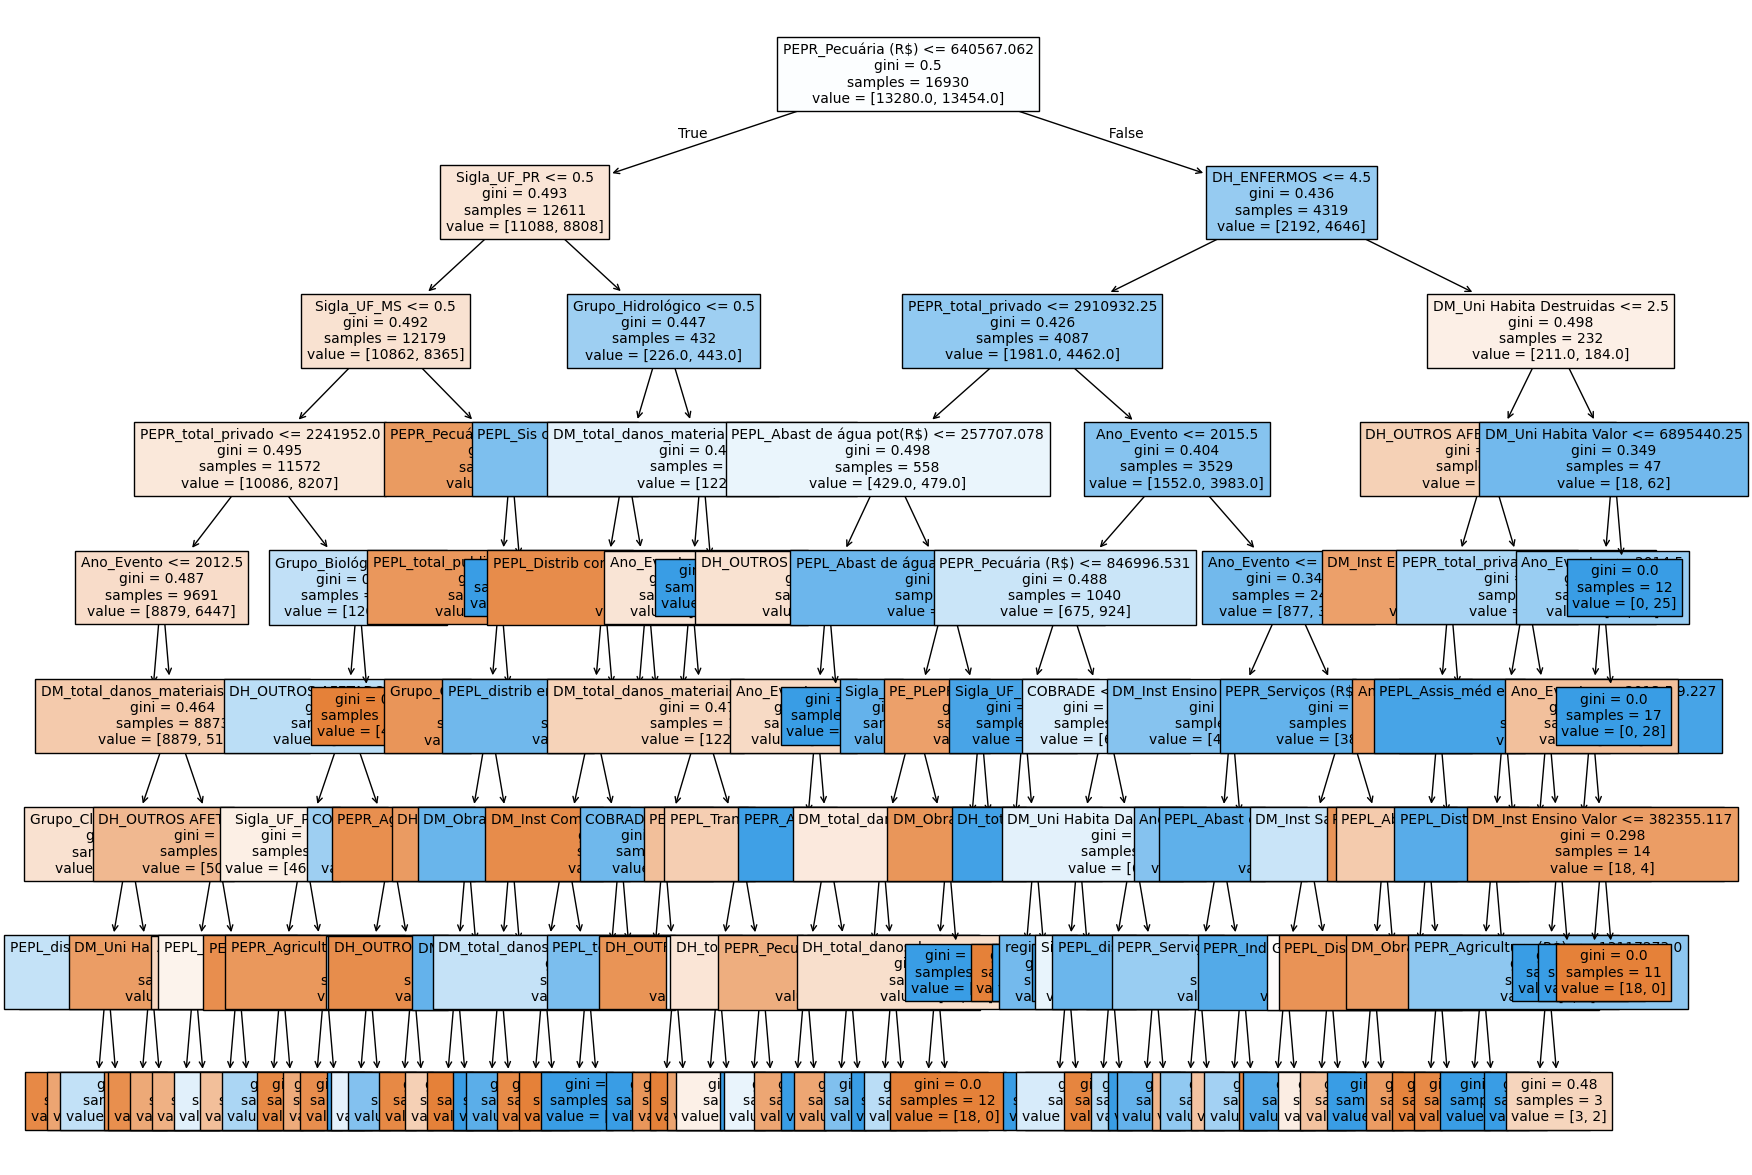

In [13]:
# "Melhor Árvore de Decisão"

# Avaliar o desempenho de cada árvore individual
best_score = 0
best_tree_index = 0

for i, tree in enumerate(rf_class_1.estimators_):
    # Previsão da árvore individual (convertendo X_test para array)
    y_pred_tree = tree.predict(X_test.values)

    # Calcular o accuracy score da árvore nos dados de teste
    score = accuracy_score(y_test, np.ravel(y_pred_tree))

    # Encontrar a árvore com o melhor score
    if score > best_score:
        best_score = score
        best_tree_index = i

print(f'A árvore com o melhor desempenho é a árvore {best_tree_index} com um score de {best_score:.4f}\n')

# Acessando a árvore com o melhor desempenho
best_tree_1 = rf_class_1.estimators_[best_tree_index]

# Visualizar a árvore
plt.figure(figsize=(20, 15))
plot_tree(best_tree_1, filled=True, fontsize=10, feature_names=X_test.columns)
plt.show()

/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


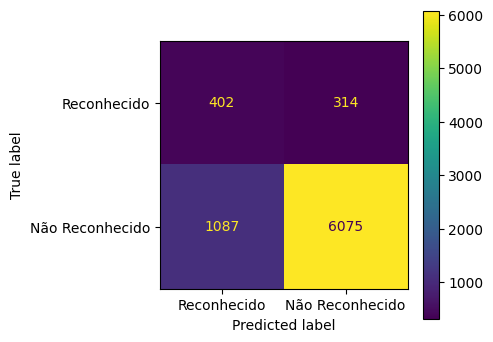

In [14]:
# Matriz de Confusão I
fig, ax = plt.subplots(figsize = (4, 4))
ConfusionMatrixDisplay.from_estimator(best_tree_1, X_test, y_test, ax = ax, values_format = 'd', display_labels=['Não Reconhecido', 'Reconhecido'])
plt.show()

# Balanceamento de Dados II

In [15]:
# Atribuir valores para X e y
X = df_novo.iloc[:,1:]
y = df_novo.Status

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Mostrar as dimensões de X e y
print('Dimensões de X_train = ', X_train.shape)
print('Dimensões de y_train = ', y_train.shape)

# Instanciar SMOTE
smote = SMOTE(random_state = 42)

# Treinar e fazer SMOTE nos dados
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Mostrar as dimensões de X e y
print('Dimensões de X_smote = ', X_train_smote.shape)
print('Dimensões de y_smote = ', y_train_smote.shape)

X_train = X_train_smote
y_train = y_train_smote

Dimensões de X_train =  (18380, 92)
Dimensões de y_train =  (18380,)
Dimensões de X_smote =  (33418, 92)
Dimensões de y_smote =  (33418,)


## Random Forest e "Melhor Árvore de Decisão" II

In [16]:
# Random Forest
rf_class_2 = RandomForestClassifier(n_estimators = 1200, max_depth = 8, random_state = 42).fit(X_train, np.ravel(y_train))
rf_class_2.score(X_test, y_test)

0.8796648895658796

/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted with

A árvore com o melhor desempenho é a árvore 16 com um score de 0.8941



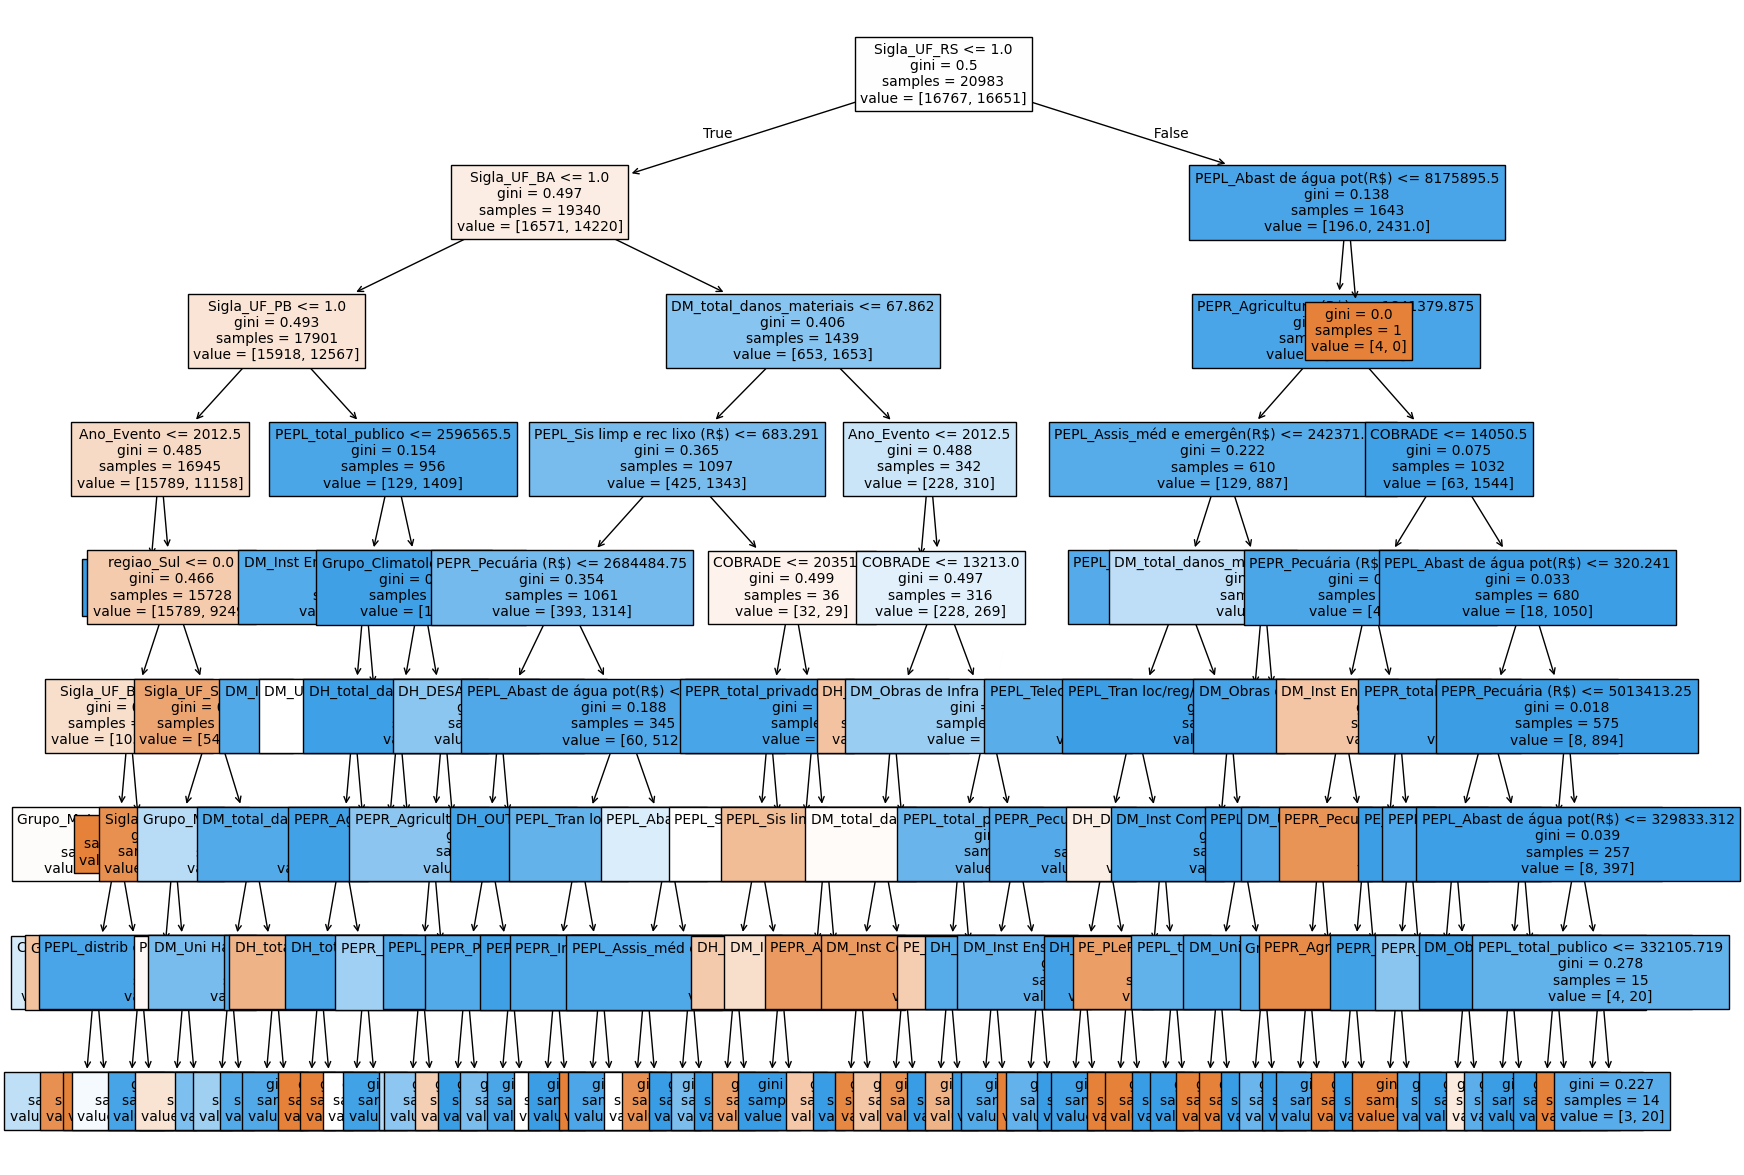

In [17]:
# "Melhor Árvore de Decisão"

# Avaliar o desempenho de cada árvore individual
best_score = 0
best_tree_index = 0

for i, tree in enumerate(rf_class_2.estimators_):
    # Previsão da árvore individual
    y_pred_tree = tree.predict(X_test)

    # Calcular o accuracy score da árvore nos dados de teste
    score = accuracy_score(y_test, np.ravel(y_pred_tree))

    # Encontrar a árvore com o melhor score
    if score > best_score:
        best_score = score
        best_tree_index = i

print(f'A árvore com o melhor desempenho é a árvore {best_tree_index} com um score de {best_score:.4f}\n')

# Acessando a árvore com o melhor desempenho
best_tree_2 = rf_class_2.estimators_[best_tree_index]

# Visualizar a árvore
plt.figure(figsize=(20, 15))
plot_tree(best_tree_2, filled=True, fontsize=10)
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


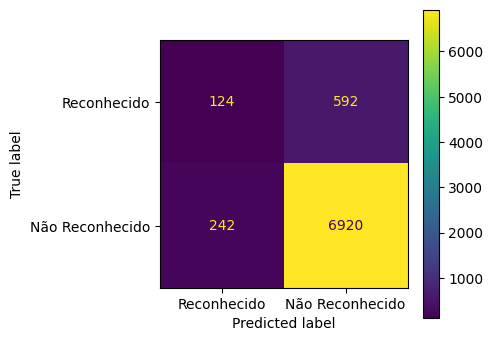

In [18]:
# Matriz de Confusão II
fig, ax = plt.subplots(figsize = (4, 4))
ConfusionMatrixDisplay.from_estimator(best_tree_2, X_test, y_test, ax = ax, values_format = 'd', display_labels=['Não Reconhecido', 'Reconhecido'])
plt.show()

## Representação Gráfica da "Melhor Árvore"

In [19]:
viz = dtreeviz.model(best_tree_2, X_train.values, y_train.values,
                target_name = "Catástrofe",
                feature_names = list(X_train.columns),
                class_names = ['0','1'])
viz.view(fontname = "monospace")

ModuleNotFoundError: No module named 'dtreeviz'

## Avaliação das Variáveis de Importância

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names


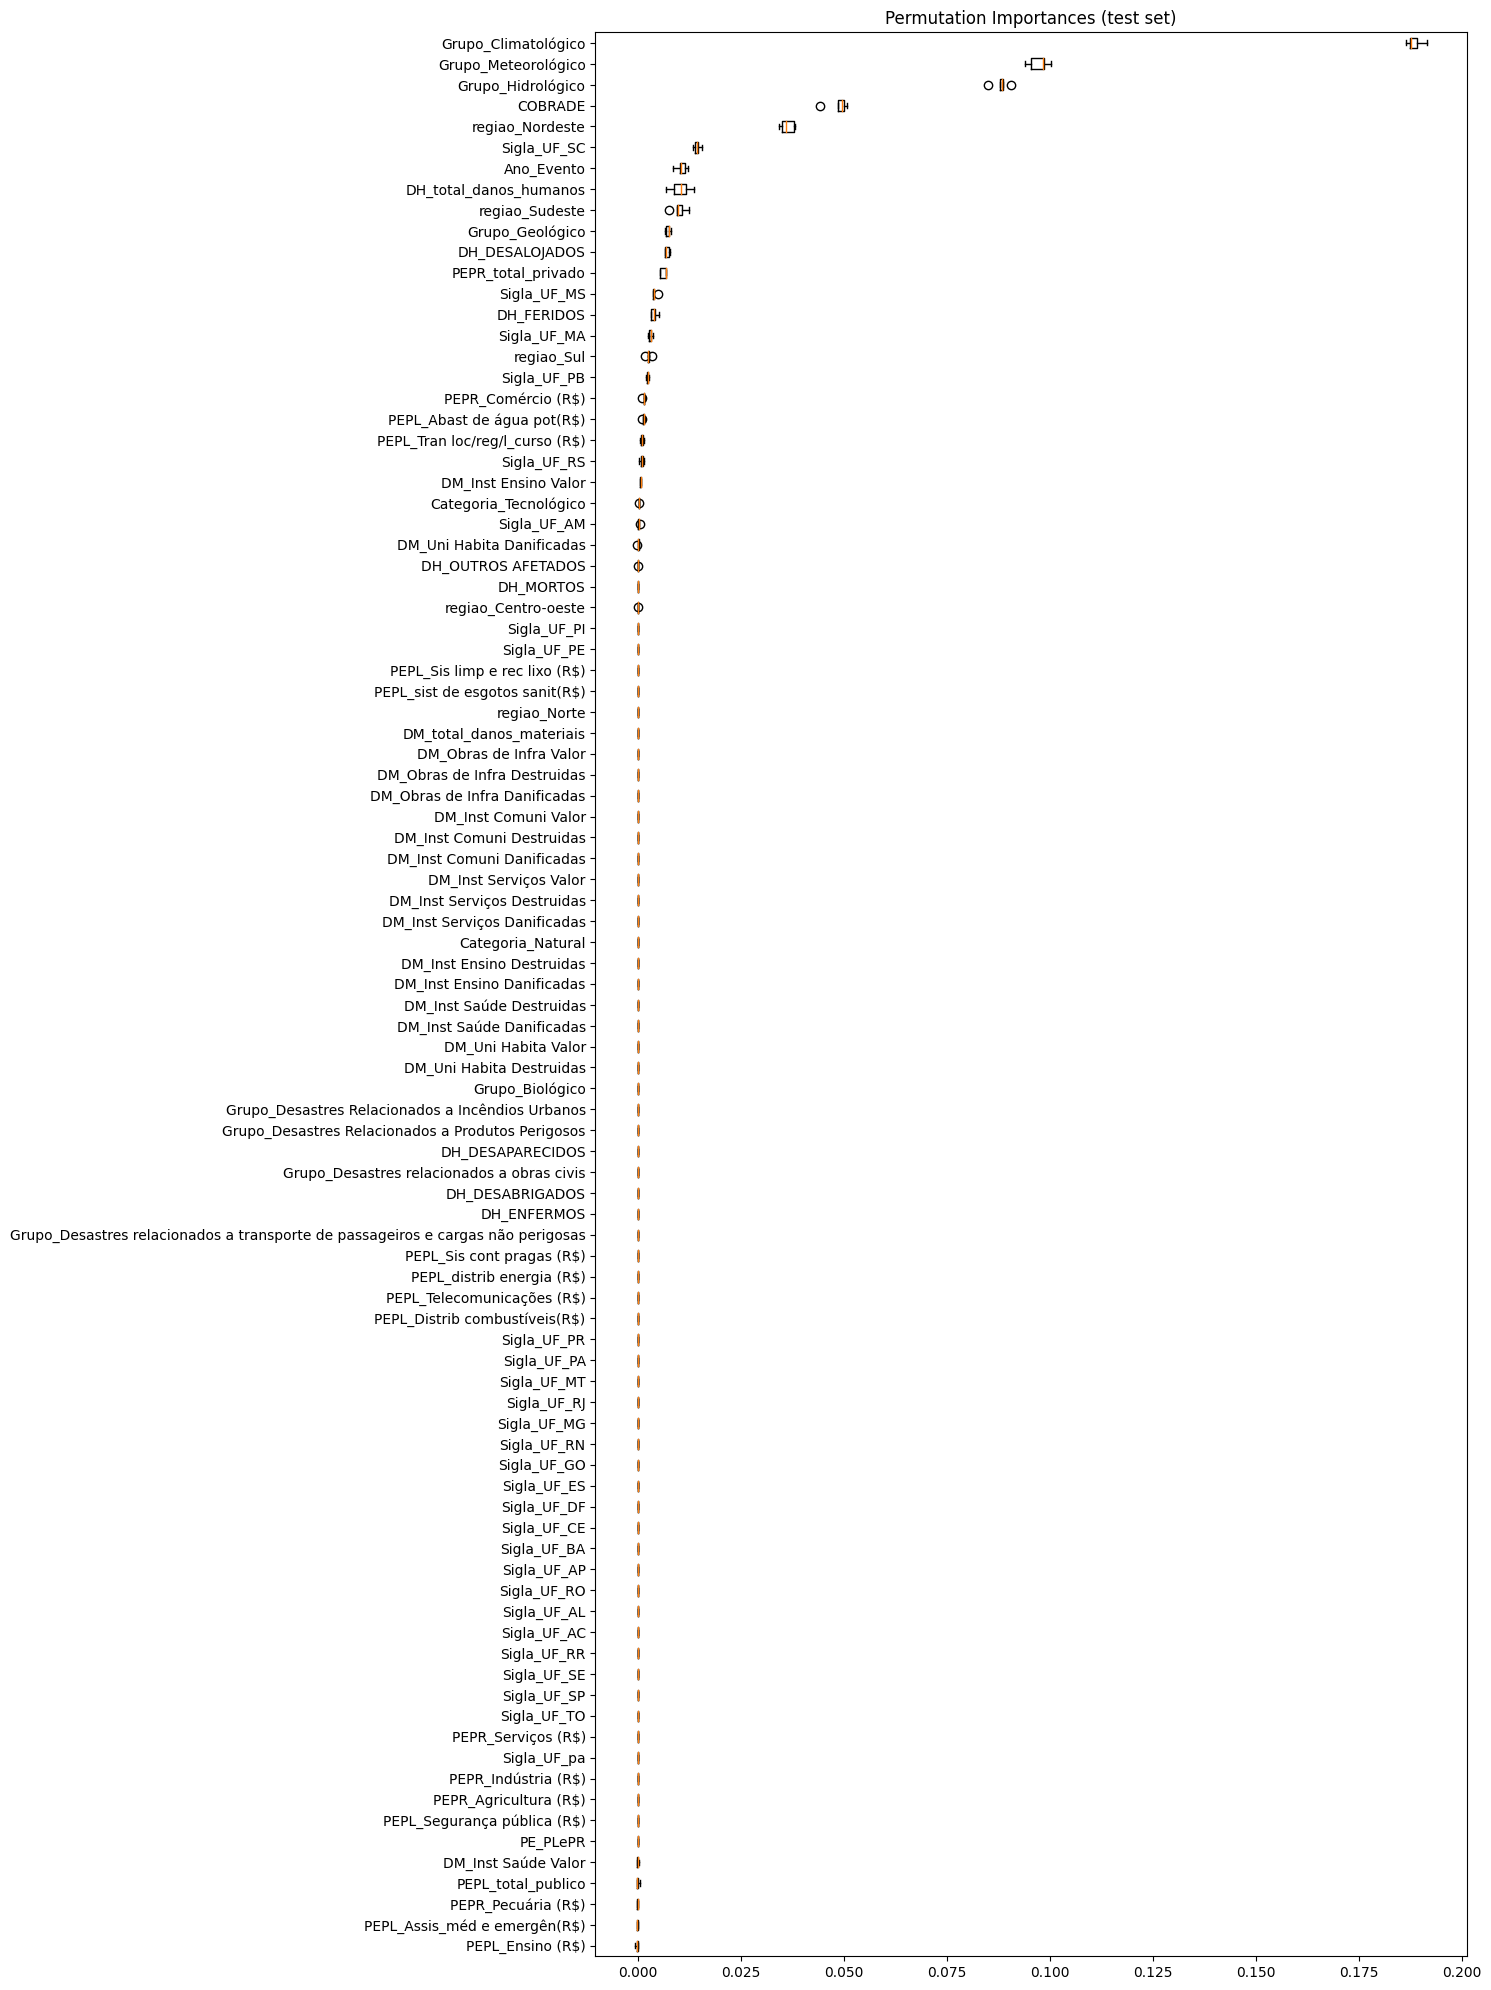

In [26]:
# Import a biblioteca (permutation_importance)
from sklearn.inspection import permutation_importance
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo ao embaralhar cada uma das variáveis.
result = permutation_importance(best_tree_2, X_test, y_test, n_repeats = 5, random_state = 42, n_jobs = -1)
# Ordenar os resultados
sorted_idx = result.importances_mean.argsort()
# Gráfico boxplot pra mostrar a importância das variáveis
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.set_size_inches(15, 20)
fig.tight_layout()
plt.show()